In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pyhf
from pathlib import Path

from publik.reweight import analysis_modifier
from publik.weights import utils as wutils
from publik.reweight import utils as rwutils
from publik.reweight import plot

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use(Path('../style.mplstyle'))
# matplotlib.style.use('default')
matplotlib.rcParams["text.usetex"] = False

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


# A simple example of how to do a fit with the model independent likelihood

## Setup the custom modifier

First we need to get the distribution of the kinematic variable, $q^2$ in the analysis binning and the corresponding binning of the variable.

In [2]:
# Get the q2 distribution
q2json = '../pyhf_inputs/pyhf_Bplus2Kplus_v24_with_continuum_weights_no_ff_q2.json'

q2dist, q2binning = rwutils.getQ2Distributions(q2json)
q2binning_cut = np.where(q2binning > 0, q2binning, 0)
q2binning_cut = np.where(q2binning_cut < wutils.kinlim(), q2binning_cut, wutils.kinlim())

Now we set up the custom modifier, knowing the $q^2$ binning and distribution. Then we can create the `pyhf` model.

In [3]:
qcent = (q2binning_cut[1:] + q2binning_cut[:-1]) / 2.0

/tmp/ipykernel_14377/3149667985.py:8: DeprecationWarning: Please use `LSQUnivariateSpline` from the `scipy.interpolate` namespace, the `scipy.interpolate.fitpack2` namespace is deprecated.
  weight = pickle.load(f)
/nfs/dust/belle1/user/lorenzg/publik/publik/reweight/analysis_modifier.py:75: RuntimeWarning: invalid value encountered in divide
  weights = BR / self.norm


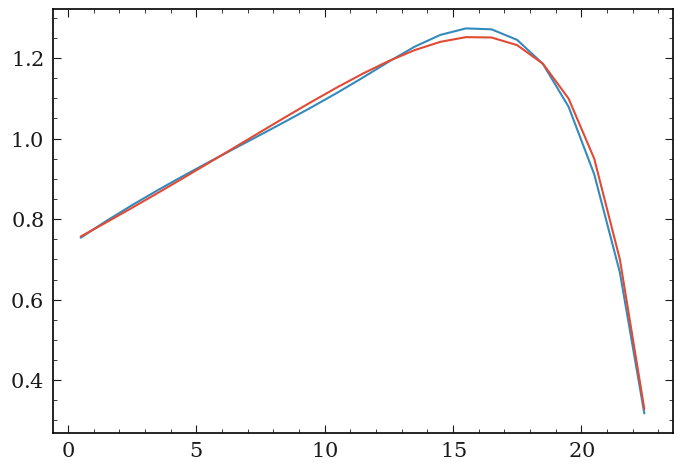

In [4]:
qcent = (q2binning_cut[1:] + q2binning_cut[:-1]) / 2.0
norm = wutils.computePHSP(q2binning_cut)
wm = analysis_modifier.weight_modifier(q2binning_cut, q2dist, norm)
# wutils.bintegrate(wm.pk, q2binning_cut, args=(wm.alpha_mean))

import pickle
with open('/nfs/dust/belle1/user/lorenzg/publik/analysis_repos/b-2-hadronnunubar-with-inclusive-tagging-new/code/b2hnn_py_modules/data/ff_weight.pkl', 'rb') as f:
    weight = pickle.load(f)
plt.plot(qcent[1:], wutils.bintegrate(weight, q2binning_cut)[1:])
plt.plot(qcent[1:], wm.getweights(wm.alpha_mean)[1:])

In [5]:
# Set up the custom modifier
expanded_pyhf = analysis_modifier.add(q2binning_cut, q2dist)

# Get the pyhf model and data
pdf, data, observations = rwutils.getPDF("../pyhf_inputs/pyhf_Bplus2Kplus_v24_with_continuum_weights_no_ff_wilson.json", validate=False, modifier_set=expanded_pyhf, return_obs=True)

# Get the pyhf model and data
# pdf, data, observations = rwutils.getPDF("../pyhf_inputs/pyhf_publication_B_K_nunu.json", return_obs=True)

INFO:pyhf.pdf:adding modifier ffpca0 (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier ffpca1 (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier ffpca2 (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier corr_neutralGamma_c (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier corr_neutralUnmatched_c (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier corr_pid_c1 (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier corr_pid_c2 (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier corr_pid_c3 (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier corr_trackingEff_c (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier corr_br_c1 (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier corr_br_c2 (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier corr_br_c3 (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier mu (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier mu_bkg_ccbar (1 new nuisance parameters)
INFO:pyhf.pdf:addin

We can check the modifiers and the constraints

In [6]:
pdf.config.par_map

{'ffpca0': {'slice': slice(0, 1, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x7fb5b30d4b50>},
 'ffpca1': {'slice': slice(1, 2, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x7fb5b30d4250>},
 'ffpca2': {'slice': slice(2, 3, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x7fb634284df0>},
 'corr_neutralGamma_c': {'slice': slice(3, 4, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x7fb5b30dd880>},
 'corr_neutralUnmatched_c': {'slice': slice(4, 5, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x7fb5b30dd7f0>},
 'corr_pid_c1': {'slice': slice(5, 6, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x7fb5b30dd5e0>},
 'corr_pid_c2': {'slice': slice(6, 7, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x7fb5b3151fd0>},
 'corr_pid_c3': {'slice': slice(7, 8, None),
  'paramset': <pyhf.parameters.paramsets.constr

/nfs/dust/belle1/user/lorenzg/publik/publik/reweight/plot.py:155: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=9)


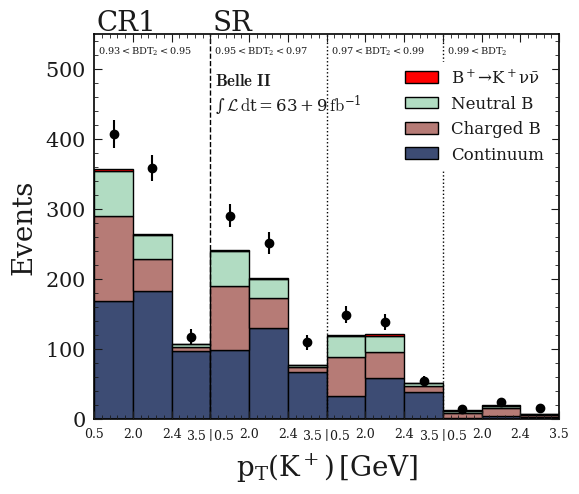

In [7]:
par_name_dict = {k: v["slice"].start for k, v in pdf.config.par_map.items()}

fig, ax = plt.subplots()
fig.set_size_inches(6, 5)
# fig.set_layout_engine(layout='tight')

# ax.set_title(f'best fit µ = {par_one[pdf.config.poi_index]:.3g}')
plot.yieldsSR(pdf, observations, par_name_dict, ax=ax)

# plt.savefig('../results/fit/WCyields_nom.pdf')
plt.show()

In [8]:
par_one = pdf.config.suggested_init()
par_one[0] = 0
par_one[1] = 0
par_one[2] = 1
par_one[12] = 10
# par_one[4] = 10

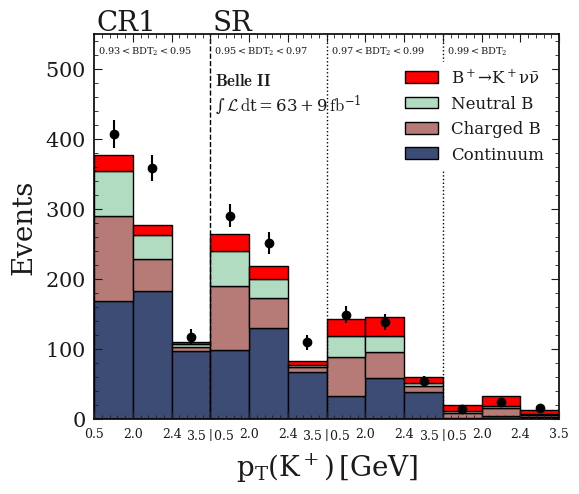

In [9]:
par_name_dict = {k: v["slice"].start for k, v in pdf.config.par_map.items()}

fig, ax = plt.subplots()
fig.set_size_inches(6, 5)
# fig.set_layout_engine(layout='tight')

# ax.set_title(f'best fit µ = {par_one[pdf.config.poi_index]:.3g}')
plot.yieldsSR(pdf, observations, par_name_dict, ax=ax, **{k: par_one[v] for k, v in par_name_dict.items()})

# plt.savefig('../results/fit/WCyields_nom.pdf')
plt.show()

## Fit

Given the model, we can now perform a simple maximum likelihood fit.

We can set the initial parameters and bounds. Since we are fitting the theory model and this includes the signal normalization, we also fix the signal strength.

In [10]:
# Here we can modify the initial parameters:
init_pars = pdf.config.suggested_init()

# Here we can modify the parameter bounds:
pdf.config.par_map['mu']['paramset'].suggested_bounds=[(-1000,1000)]
par_bounds = pdf.config.suggested_bounds()

# Here we can fix parameters:
fixed = np.full(len(pdf.config.par_names), False)
# fixed[pdf.config.poi_index]=True
# for i in range(3):
#     fixed[pdf.config.par_map[f'ffpca{i}']['slice']]=[True]

`pyhf` supports a number of optimizers. `scipy` is the most stable in general, but does not return uncertainties. `minuit` will return uncertainties. Below we perforn fits with both optimizers.

### Scipy optimizer

In [11]:
pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer())
   
best_fit, twice_nll = pyhf.infer.mle.fit(data, 
                                        pdf, 
                                        init_pars, 
                                        par_bounds, 
                                        fixed.tolist(),
                                        return_fitted_val=True, 
                                    #  return_result_obj=True
                                        )


best_fit_dict = {k: best_fit[v["slice"]].tolist() for k, v in pdf.config.par_map.items()}
        
results_scipy = { 'twice_nll': float(twice_nll), 
            'fit_values': best_fit_dict}

In [12]:
results_scipy

{'twice_nll': -53.4151284024631,
 'fit_values': {'ffpca0': [0.0037352102890435535],
  'ffpca1': [-0.0019245160024809354],
  'ffpca2': [0.00036669438688885286],
  'corr_neutralGamma_c': [0.16512003201324382],
  'corr_neutralUnmatched_c': [0.6799327204706795],
  'corr_pid_c1': [0.0608794011093749],
  'corr_pid_c2': [0.030361134316239602],
  'corr_pid_c3': [-0.027932222067632854],
  'corr_trackingEff_c': [0.12126942804172582],
  'corr_br_c1': [-0.01882904259820061],
  'corr_br_c2': [0.015700141292571627],
  'corr_br_c3': [0.007421750053260697],
  'mu': [4.229716967201967],
  'mu_bkg_ccbar': [0.8611588663478261],
  'mu_bkg_charged': [-0.01202956062613689],
  'mu_bkg_ddbar': [0.0859777366728919],
  'mu_bkg_mixed': [-0.04750071982057199],
  'mu_bkg_ssbar': [0.7195524714910088],
  'mu_bkg_taupair': [0.005403467110846536],
  'mu_bkg_uubar': [0.060919352717189935],
  'uncorr_bkguncrt_ccbar_zoomCR_Y4S': [0.9916218519352794,
   1.0158205242366565,
   0.9713566862625899],
  'uncorr_bkguncrt_ccbar_

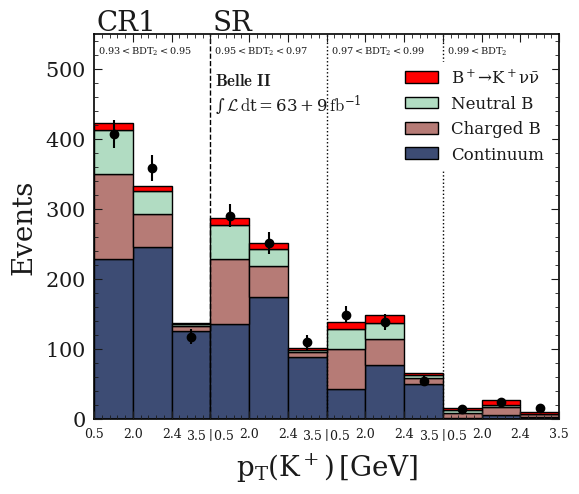

In [13]:
par_name_dict = {k: v["slice"].start for k, v in pdf.config.par_map.items()}

fig, ax = plt.subplots()
fig.set_size_inches(6, 5)
# fig.set_layout_engine(layout='tight')

# ax.set_title(f'best fit µ = {par_one[pdf.config.poi_index]:.3g}')
plot.yieldsSR(pdf, observations, par_name_dict, ax=ax, **{k: best_fit[v] for k, v in par_name_dict.items()})

plt.savefig('../results/fit/yields_post_fit_reproduced.pdf')
plt.show()

## Yield differences to HEPData

In [14]:
import yaml 

anafile = '../hepdata/postfit_yields_Y4S.yaml'
with open(anafile) as f:
    hepy4s = yaml.safe_load(f)
    
anafile = '../hepdata/postfit_yields_offres.yaml'
with open(anafile) as f:
    hepoff = yaml.safe_load(f)
def reorder(l):
    n = len(l)
    order = np.concatenate((np.arange(3, n), np.arange(3)))
    return  np.array([l[i] for i in order])

def clean(name):
    rm = ['Number', 'of', 'events', 'backgrounds', 'backgrounda', 'from', 'Observed','rightarrow', '^', '\\', '$', ' ']
    for r in rm:
        name = name.replace(r, '')
    return name

def combinedicts(d1, d2):
    d = {}
    for k1 in d1.keys():
        if k1 in d2:
            d[k1] = np.concatenate((d1[k1], d2[k1]))
        else:
            d[k1] = np.concatenate((d1[k1], np.zeros(len(d1[k1]))))
    for k2 in d2.keys():
        if k2 not in d:
            d[k2] = np.concatenate((d2[k2], np.zeros(len(d2[k2]))))
    return d

off = {clean(h['header']['name']):reorder([v['value'] for v in h['values']])
 for h in hepoff['dependent_variables']}
y4s = {clean(h['header']['name']):reorder([v['value'] for v in h['values']])
 for h in hepy4s['dependent_variables']}

hepdata = combinedicts(y4s, off)


In [15]:
yields = {k: v for k, v in zip(pdf.config.samples,
    pdf.main_model.expected_data(best_fit, return_by_sample=True))}
yields['obs'] = observations

In [16]:
yieldkeys = ['obs', 'signal', 'charged', 'mixed', 'ccbar', 'ddbar', 'ssbar', 'taupair', 'uubar',]
hepkeys = ['data', 'signalB+K+nubarnu', 'chargedB', 'neutralB', 'cbarc', 'dbard', 'sbars', 'tautau', 'ubaru']

diffdict = {}
for yk, hk in zip(yieldkeys, hepkeys):
    print(yk)
    diff = yields[yk]-hepdata[hk]
    #where = np.where(np.array(yields[yk]) != 0, True, False)
    #np.divide((yields[yk]-hepdata[hk]), hepdata[hk], out=diff, where=where)
    print(diff)
    diffdict[yk] = diff
    # if np.where(diff>1e-1)[0].size > 0:
    #     warnings.warn("Differences found.")

obs
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
signal
[0.06815251 0.02352821 0.01399061 0.06435097 0.0394185  0.0344493
 0.02039986 0.03465349 0.02839244 0.0682598  0.01292754 0.01122047
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
charged
[-0.52858422 -0.24960283 -0.03667258 -0.34251528 -0.22058189 -0.04224892
 -0.04603973 -0.0636739  -0.02078522 -0.673786   -0.2651678  -0.03210661
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
mixed
[0.51466171 0.27767245 0.02892121 0.30646336 0.2293771  0.04150202
 0.03225394 0.0400082  0.00827584 0.6761672  0.36594439 0.03864429
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
ccbar
[ 1.86951979e-01  2.44102691e-01  1.22909680e-01  5.73291010e-02
  9.70571035e-02  6.2958

## Upper limit

In [17]:
pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer())

# Here we can modify the initial parameters:
init_pars = pdf.config.suggested_init()

# Here we can modify the parameter bounds:
pdf.config.par_map['mu']['paramset'].suggested_bounds=[(-1000,1000)]
par_bounds = pdf.config.suggested_bounds()

# Here we can fix parameters:
fixed = np.full(len(pdf.config.par_names), False)
# fixed[pdf.config.poi_index]=True
# fixed[pdf.config.par_map['ffpca0']['slice']]=[True]
# fixed[pdf.config.par_map['ffpca1']['slice']]=[True]
# fixed[pdf.config.par_map['ffpca2']['slice']]=[True]

poi_values = np.linspace(0.1, 10, 20)
obs_limit, exp_limits, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(
    data, pdf, poi_values, level=0.1, return_results=True, test_stat="q", init_pars= init_pars, par_bounds=par_bounds, fixed_params=list(fixed)
)
print(f"Upper limit (obs): μ = {obs_limit:.4f}")
print(f"Upper limit (exp): μ = {exp_limits[2]:.4f}")

/nfs/dust/belle1/user/lorenzg/publik/publik/reweight/analysis_modifier.py:75: RuntimeWarning: invalid value encountered in divide
  weights = BR / self.norm


Upper limit (obs): μ = 8.8477
Upper limit (exp): μ = 5.4972


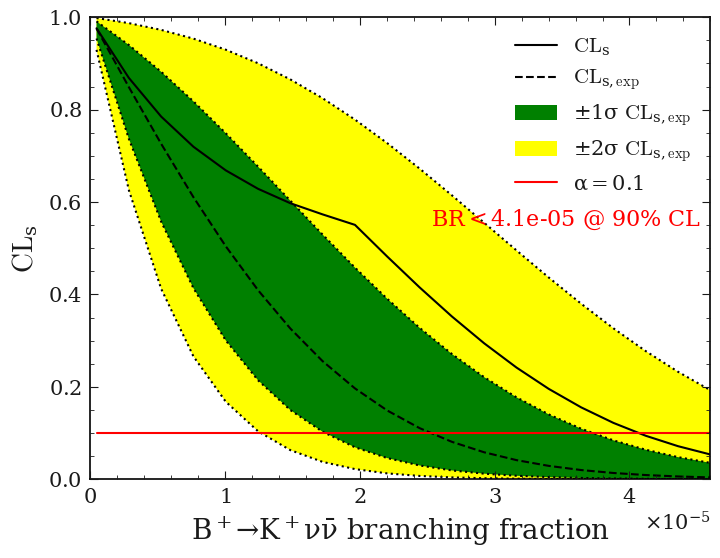

In [54]:
from pyhf.contrib.viz import brazil

br = 4.6e-6
br_values = poi_values * br

fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
# ax.set_title("Hypothesis Tests")
artists = brazil.plot_results(br_values, results, ax=ax, test_size=0.1)
ax.set_xlim((0,10*br))
ax.set_xlabel(r'$B^+ \to K^+ \nu \bar \nu$ branching fraction')
ax.text(5.5*br,0.55, r'$BR < $' + f'{(obs_limit*br):.2}' + r' @ 90% CL', c='r', fontsize=16)
plt.savefig('../results/fit/limit_reproduced.pdf')
plt.show()
